In [1]:
#import gdown
import os, zipfile
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
download=False

In [2]:
if download:
    url = 'https://drive.google.com/file/d/1qw7RzbapSzUKCWEu1zsKR4SxyNgoVsSh/view?usp=drive_link'
    output = os.path.join(os.getcwd(), 'mitbih-dataset.zip')
    gdown.download(url, output, quiet=False)
    zip_ref=zipfile.ZipFile("mitbih-dataset.zip",'r')
    zip_ref.extractall(".")
    zip_ref.close()
    print("Ok")

In [8]:
df_train = pd.read_csv('dataset/mitbih_train.csv', header=None)
df_test = pd.read_csv('dataset/mitbih_test.csv', header=None)
print(df_train.head(10))

        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   
5  0.927461  1.000000  0.626943  0.193437  0.094991  0.072539  0.043178   
6  0.423611  0.791667  1.000000  0.256944  0.000000  0.277778  0.465278   
7  0.716814  0.539823  0.283186  0.129794  0.064897  0.076696  0.026549   
8  0.874214  0.849057  0.480084  0.058700  0.090147  0.310273  0.387841   
9  1.000000  0.996086  0.694716  0.336595  0.238748  0.268102  0.191781   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0

In [4]:
label_map = {
    0: "Normal (N)",
    1: "Atrial Premature (A)",
    2: "Premature Ventricular Contraction (V)",
    3: "Fusion (F)",
    4: "Paced (/)",
}

df_train['label_name'] = df_train.iloc[:, -1].map(label_map)  # Assumes last column is numeric label
print(df_train[['label_name']].value_counts())

label_name                           
Normal (N)                               72471
Paced (/)                                 6431
Premature Ventricular Contraction (V)     5788
Atrial Premature (A)                      2223
Fusion (F)                                 641
Name: count, dtype: int64


In [5]:
df_test['label_name'] = df_test.iloc[:, -1].map(label_map)  # Assumes last column is numeric label
print(df_test[['label_name']].value_counts())

label_name                           
Normal (N)                               18118
Paced (/)                                 1608
Premature Ventricular Contraction (V)     1448
Atrial Premature (A)                       556
Fusion (F)                                 162
Name: count, dtype: int64


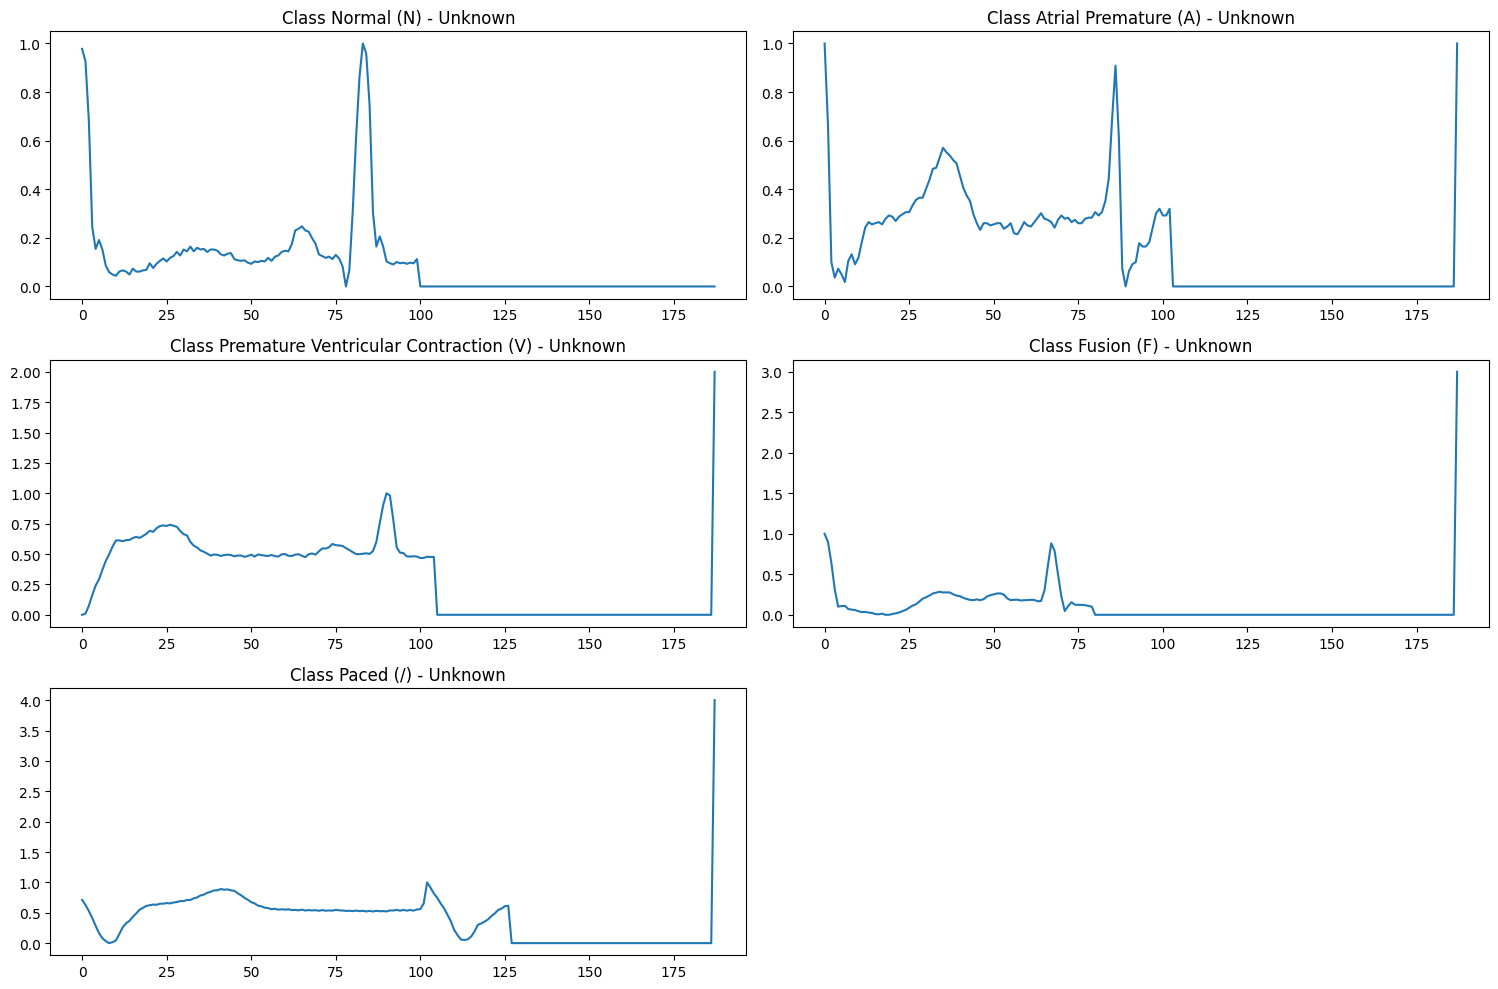

In [6]:
classes = df_train.iloc[:, -1].unique()
plt.figure(figsize=(15, 10))
for i, label in enumerate(classes):
    plt.subplot(3, 2, i+1)
    sample = df_train[df_train.iloc[:, -1] == label].iloc[0, :-1]
    plt.plot(sample)
    plt.title(f"Class {label} - {label_map.get(label, 'Unknown')}")
plt.tight_layout()
plt.show()

In [10]:
class ECGDataset(Dataset):
    pass